In [1]:
import numpy
import xarray
import glob
import pandas
import cartopy
import itertools
import matplotlib
import cmocean
import netCDF4
import datetime
import cftime

import matplotlib.pyplot as mp

mp.rcParams.update({'mathtext.default': 'regular'})
%matplotlib inline

In [2]:
# PRECT_orig = '/scratch/blangenb/NCAR_LENS/PRECT/b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.04020101-04991231.nc'
PRECT_orig = '/glade/p_old/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PRECC/b.e11.B1850C5CN.f09_g16.005.cam.h0.PRECC.040001-049912.nc'
PRECT_orig_ds = xarray.open_dataset(PRECT_orig)
lat_full = PRECT_orig_ds['lat'].values
lon_full = PRECT_orig_ds['lon'].values

In [3]:
#PRECT_root = '/ninad/NCAR_LENS/PRECT/'
PRECC_root = '/glade/p_old/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PRECC/'
PRECL_root = '/glade/p_old/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PRECL/'
#PRECT_root = '/scratch/blangenb/NCAR_LENS/PRECT_lonslices/'
#PRECT_root =  '/glade/p_old/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/PRECT/'

In [4]:
pic_file_list_PRECC = numpy.array(sorted(glob.glob(PRECC_root+'/b.e11.B1850C5CN.f09_g16.*.nc')))
pic_file_list_PRECL = numpy.array(sorted(glob.glob(PRECL_root+'/b.e11.B1850C5CN.f09_g16.*.nc')))

In [5]:
rcp_file_list_PRECC = numpy.array(sorted(glob.glob(PRECC_root+'/b.e11.BRCP85C5CNBDRD.f09_g16.*.nc')))
rcp_file_list_PRECL = numpy.array(sorted(glob.glob(PRECL_root+'/b.e11.BRCP85C5CNBDRD.f09_g16.*.nc')))

# open pic files

In [6]:
PRECC_pic_mfds = xarray.open_mfdataset(pic_file_list_PRECC, decode_times=False)
PRECL_pic_mfds = xarray.open_mfdataset(pic_file_list_PRECL, decode_times=False)

In [7]:
PRECT_pic = (PRECC_pic_mfds['PRECC']+PRECL_pic_mfds['PRECL']).values*86400.*1000.

In [8]:
pic_time_datetime = numpy.array([cftime.DatetimeNoLeap(year,month,1) \
                                 for year,month in itertools.product(range(400,2201), range(1, 13))])

# open hist/rcp files

In [9]:
# define member strings for hist/rcp
multifile_members = ['{:03d}'.format(i) for i in range(1,34)]
all_members = ['{:03d}'.format(i) for i in range(1,36)] + ['{:03d}'.format(i) for i in range(101,106)]

In [10]:
rcp_time_datetime = numpy.array([cftime.DatetimeNoLeap(year,month,1) \
                                 for year,month in itertools.product(range(2006,2101), range(1,13))])

In [11]:
rcp_start = cftime.DatetimeNoLeap(2070,1,1)
rcp_end = cftime.DatetimeNoLeap(2099,12,31)
rcp_time_indices = list(numpy.where((rcp_time_datetime>=rcp_start)&(rcp_time_datetime<=rcp_end))[0])

In [12]:
rcp_nyears = 30
rcp_year_array = numpy.arange(rcp_start.year, rcp_end.year+1, dtype=numpy.int)
rcp_time_datetime_subset = rcp_time_datetime[rcp_time_indices]

In [13]:
PRECT_all_rcp_data = numpy.zeros((all_members.__len__(), rcp_nyears*12, lat_full.size, lon_full.size))

In [14]:
# do all this for the first lon box to get the time and lat/lon information
for member_idx in range(40):
    
    which_member = all_members[member_idx]
    #print(which_member)

    PRECC_file_indices = [file.split('/')[-1].split('.')[4]==which_member for file in rcp_file_list_PRECC]
    PRECL_file_indices = [file.split('/')[-1].split('.')[4]==which_member for file in rcp_file_list_PRECL]

    PRECC_member_file_list = rcp_file_list_PRECC[PRECC_file_indices]
    PRECL_member_file_list = rcp_file_list_PRECL[PRECL_file_indices]

    if PRECC_member_file_list.__len__()!=PRECL_member_file_list.__len__():
        print('weird not same length')
    elif PRECC_member_file_list.__len__()>1:
        PRECC_rcp_ds = xarray.open_mfdataset(PRECC_member_file_list)
        PRECL_rcp_ds = xarray.open_mfdataset(PRECL_member_file_list)
    else:
        PRECC_rcp_ds = xarray.open_dataset(PRECC_member_file_list[0])
        PRECL_rcp_ds = xarray.open_dataset(PRECL_member_file_list[0])

    # prect_rcp = prect_rcp_ds['PRECT']*86400.*1000.

    PRECT_rcp_ds = (PRECC_rcp_ds['PRECC']+PRECL_rcp_ds['PRECL']).isel(time=rcp_time_indices)
    PRECT_all_rcp_data[member_idx,:,:,:] = PRECT_rcp_ds.values*86400.*1000.

# doing seasonal means for pic

In [15]:
window_length=6 # ONDJFM, AMJJAS

In [16]:
# calculate rolling mean
# pick off the window that matters
# take seasonal means of data set
pic_nyears = pic_time_datetime[-1].year - pic_time_datetime[0].year
pic_year_start = pic_time_datetime[0].year
pic_year_end = pic_time_datetime[-1].year
pic_year_array = numpy.arange(pic_year_start, pic_year_start+pic_nyears, dtype=numpy.int)

PRECT_pic_rolling_means = numpy.zeros((PRECT_pic.shape))
for j in range(lat_full.size):
    if j%50==0:
        print(j)
    for k in range(lon_full.size):
        PRECT_pic_rolling_means[:,j,k] = pandas.Series(PRECT_pic[:,j,k]).rolling(window=window_length, min_periods=1).mean()

#

0
50
100
150


# take moving window means of hist

In [17]:
PRECT_rcp_rolling_means = numpy.zeros((PRECT_all_rcp_data.shape))
for member_idx in range(40):
    print(member_idx)
    for j in range(lat_full.size):
        for k in range(lon_full.size):
            PRECT_rcp_rolling_means[member_idx,:,j,k] = pandas.Series(PRECT_all_rcp_data[member_idx,:,j,k]).rolling(window=window_length, min_periods=1).mean()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [65]:
SEAS_list = [10,11,12,1,2,3]; SEAS_name = 'ONDJFM'; window_length=6
#SEAS_list = [4,5,6,7,8,9]; SEAS_name = 'AMJJAS'; split=False
#SEAS_list = [12,1,2]; SEAS_name = 'DJF'; window_length=3

# pull out pic seasons

In [66]:
pic_seas_endmonth_indices = [(d.month==SEAS_list[-1]) for d in pic_time_datetime]
PRECT_pic_seas_means = PRECT_pic_rolling_means[pic_seas_endmonth_indices,:,:][1:-1,:,:]

# calculating return periods of seasonal means

In [67]:
return_period = 100 # in years

In [68]:
events_per_year = 1
return_val_perc = 100*(1-1/(return_period*events_per_year))
print(return_val_perc)

pic_hi_percentile_values = numpy.zeros((lat_full.size,lon_full.size))
for j in range(lat_full.size):
    for k in range(lon_full.size):
        tmp_distro = PRECT_pic_seas_means[:,j,k]
        pic_hi_percentile_values[j,k] = numpy.percentile(tmp_distro, return_val_perc)

99.0


In [69]:
events_per_year = 1
return_val_perc = 100*(1/(return_period*events_per_year))
print(return_val_perc)

pic_lo_percentile_values = numpy.zeros((lat_full.size,lon_full.size))
for j in range(lat_full.size):
    for k in range(lon_full.size):
        tmp_distro = PRECT_pic_seas_means[:,j,k]
        pic_lo_percentile_values[j,k] = numpy.percentile(tmp_distro, return_val_perc)

1.0


# plot return period values of pic

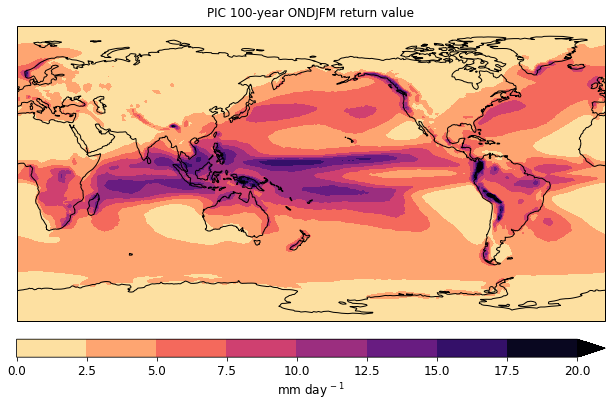

In [70]:
fontsize=12

map_proj = cartopy.crs.PlateCarree(central_longitude=180)
data_proj = cartopy.crs.PlateCarree(central_longitude=0)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines()

ax.text(s='PIC 100-year '+SEAS_name+' return value', x=0.5, y=1.02, ha='center', va='bottom', fontsize=fontsize, \
       transform=ax.transAxes)

clevels = numpy.arange(0,21,2.5)
plot = ax.contourf(lon_full, lat_full, pic_hi_percentile_values, \
                   levels=clevels, \
                   transform=data_proj, \
                   cmap='magma_r', extend='max')

fig.tight_layout()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0, axpos.y0-.1, axpos.width, 0.05])
cbar_ax.tick_params(labelsize=fontsize)

cbar = fig.colorbar(plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('mm day$^{\,-1}$', fontsize=fontsize)

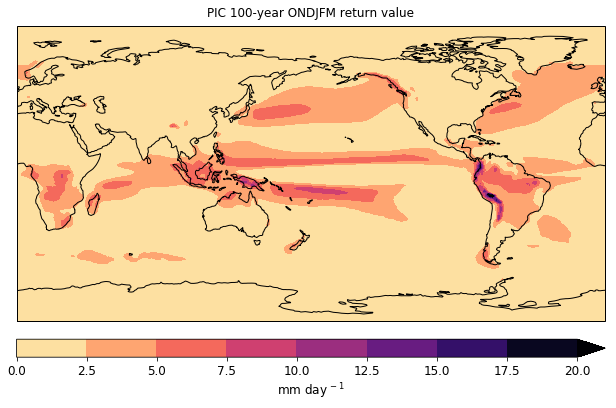

In [71]:
fontsize=12

map_proj = cartopy.crs.PlateCarree(central_longitude=180)
data_proj = cartopy.crs.PlateCarree(central_longitude=0)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines()

ax.text(s='PIC 100-year '+SEAS_name+' return value', x=0.5, y=1.02, ha='center', va='bottom', fontsize=fontsize, \
       transform=ax.transAxes)

clevels = numpy.arange(0,21,2.5)
plot = ax.contourf(lon_full, lat_full, pic_lo_percentile_values, \
                   levels=clevels, \
                   transform=data_proj, \
                   cmap='magma_r', extend='max')

fig.tight_layout()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0, axpos.y0-.1, axpos.width, 0.05])
cbar_ax.tick_params(labelsize=fontsize)

cbar = fig.colorbar(plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('mm day$^{\,-1}$', fontsize=fontsize)

# pull out rcp seasons

In [72]:
rcp_seas_endmonth_indices = [(d.month==SEAS_list[-1]) for d in rcp_time_datetime_subset]
PRECT_rcp_seas_means = numpy.zeros((all_members.__len__(), sum(rcp_seas_endmonth_indices), lat_full.size, lon_full.size))

for member_idx in range(40):
    PRECT_rcp_seas_means[member_idx,:,:,:] = PRECT_rcp_rolling_means[member_idx,rcp_seas_endmonth_indices,:,:]
PRECT_rcp_seas_means = PRECT_rcp_seas_means[:,1:-1,:,:]

# just for funsies, calculate the 20th and 80th percentiles for RCP

In [97]:
PRECT_rcp_seas_means.shape

(40, 28, 192, 288)

In [98]:
events_per_year = 1
return_val_perc = 100*(1-1/(return_period*events_per_year))
print(return_val_perc)

rcp_hi_percentile_values = numpy.zeros((lat_full.size,lon_full.size))
for j in range(lat_full.size):
    for k in range(lon_full.size):
        tmp_distro = PRECT_rcp_seas_means[:,:,j,k]
        rcp_hi_percentile_values[j,k] = numpy.percentile(tmp_distro, return_val_perc)

99.0


In [99]:
events_per_year = 1
return_val_perc = 100*(1/(return_period*events_per_year))
print(return_val_perc)

rcp_lo_percentile_values = numpy.zeros((lat_full.size,lon_full.size))
for j in range(lat_full.size):
    for k in range(lon_full.size):
        tmp_distro = PRECT_rcp_seas_means[:,:,j,k]
        rcp_lo_percentile_values[j,k] = numpy.percentile(tmp_distro, return_val_perc)

1.0


# count exceedances using pic calculation

In [73]:
PRECT_rcp_exceedance_counts = numpy.zeros((lat_full.size, lon_full.size))

for j in range(lat_full.size):
    for k in range(lon_full.size):
        PRECT_rcp_exceedance_counts[j,k] = numpy.sum(PRECT_rcp_seas_means[:,:,j,k]>pic_hi_percentile_values[j,k])

In [74]:
PRECT_rcp_deceedance_counts = numpy.zeros((lat_full.size, lon_full.size))

for j in range(lat_full.size):
    for k in range(lon_full.size):
        PRECT_rcp_deceedance_counts[j,k] = numpy.sum(PRECT_rcp_seas_means[:,:,j,k]<pic_lo_percentile_values[j,k])

In [75]:
rcp_nyears_seas_means = PRECT_rcp_seas_means.shape[1]
pic_nyears_seas_means = PRECT_pic_seas_means.shape[0]

In [76]:
PRECT_rcp_normalized_exceedances = PRECT_rcp_exceedance_counts/(rcp_nyears_seas_means*40)/((pic_nyears_seas_means/return_period)/pic_nyears_seas_means)
PRECT_rcp_normalized_deceedances = PRECT_rcp_deceedance_counts/(rcp_nyears_seas_means*40)/((pic_nyears_seas_means/return_period)/pic_nyears_seas_means)


In [77]:
# make color map
minval=0.0 
maxval=0.95
n=256
full_cmap = cmocean.cm.balance_r
full_cmap_r = cmocean.cm.balance
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))
cmap_partial_r = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap_r.name, a=minval, b=maxval), full_cmap_r(numpy.linspace(minval, maxval, n)))

In [78]:
#clevels = numpy.hstack((numpy.arange(0,1.1,0.1), numpy.arange(5,50.1,5)))
clevels = numpy.hstack((numpy.arange(0,1.1,0.1), numpy.array([2,3,4,5,10,15,20,30,50,100])))
bounds = clevels
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

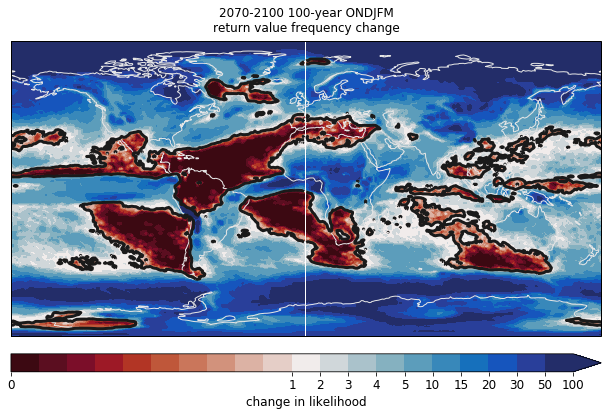

In [80]:
fontsize=12

map_proj = cartopy.crs.PlateCarree(central_longitude=0)
data_proj = cartopy.crs.PlateCarree(central_longitude=0)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines(color='0.9')

ax.text(s='2070-2100 100-year '+SEAS_name+'\nreturn value frequency change', \
        x=0.5, y=1.02, ha='center', va='bottom', fontsize=fontsize, \
        transform=ax.transAxes)

plot = ax.contourf(lon_full, lat_full, PRECT_rcp_normalized_exceedances, \
                   levels=clevels, \
                   transform=data_proj, extend='max', \
                   cmap=cmap_partial, norm=norm)

#plot = ax.pcolormesh(lon_full, lat_full, PRECT_rcp_normalized_exceedances, vmin=0, vmax=2, cmap='RdBu', transform=data_proj)

plot_one = ax.contour(lon_full, lat_full, PRECT_rcp_normalized_exceedances, \
                      levels=[1.0], linewidths=[3], colors=['0.1'], transform=data_proj)

fig.tight_layout()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0, axpos.y0-.1, axpos.width, 0.05])
cbar_ax.tick_params(labelsize=fontsize)

cbar = fig.colorbar(plot, orientation='horizontal',cax=cbar_ax)
cbar.set_ticks([0,1,2,3,4,5,10,15,20,30,50,100])
cbar.set_label('change in likelihood', fontsize=fontsize)

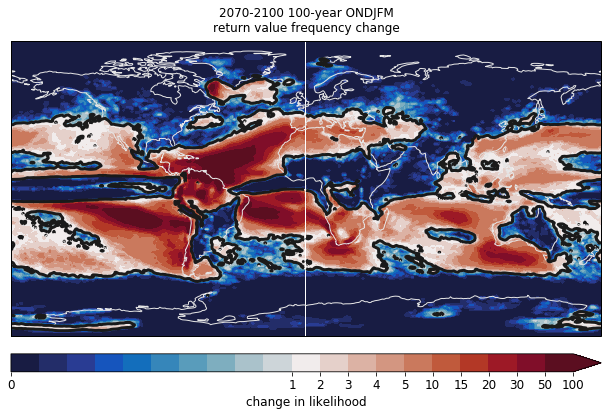

In [81]:
fontsize=12

map_proj = cartopy.crs.PlateCarree(central_longitude=0)
data_proj = cartopy.crs.PlateCarree(central_longitude=0)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines(color='0.9')

ax.text(s='2070-2100 100-year '+SEAS_name+'\nreturn value frequency change', \
        x=0.5, y=1.02, ha='center', va='bottom', fontsize=fontsize, \
        transform=ax.transAxes)

plot = ax.contourf(lon_full, lat_full, PRECT_rcp_normalized_deceedances, \
                   levels=clevels, \
                   transform=data_proj, extend='max', \
                   cmap=cmap_partial_r, norm=norm)

plot_one = ax.contour(lon_full, lat_full, PRECT_rcp_normalized_deceedances, \
                      levels=[1.0], linewidths=[3], colors=['0.1'], transform=data_proj)

fig.tight_layout()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0, axpos.y0-.1, axpos.width, 0.05])
cbar_ax.tick_params(labelsize=fontsize)

cbar = fig.colorbar(plot, orientation='horizontal',cax=cbar_ax)
cbar.set_ticks([0,1,2,3,4,5,10,15,20,30,50,100])
cbar.set_label('change in likelihood', fontsize=fontsize)

In [82]:
threshold = 1.5

In [83]:
sign_switch_regions = numpy.array((PRECT_rcp_normalized_deceedances>threshold)&(PRECT_rcp_normalized_exceedances>threshold), dtype=numpy.float)
sign_switch_regions[sign_switch_regions==0]=numpy.nan

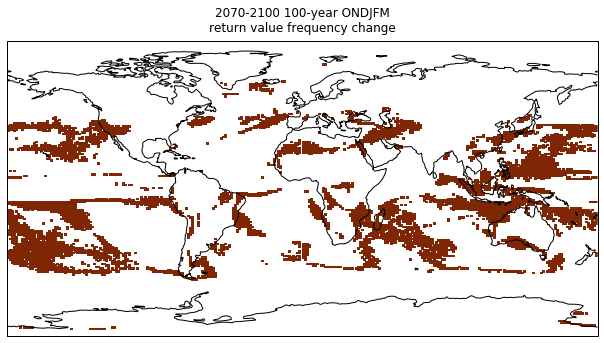

In [84]:
fontsize=12

map_proj = cartopy.crs.PlateCarree(central_longitude=0)
data_proj = cartopy.crs.PlateCarree(central_longitude=0)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines()

ax.text(s='2070-2100 100-year '+SEAS_name+'\nreturn value frequency change', \
        x=0.5, y=1.02, ha='center', va='bottom', fontsize=fontsize, \
        transform=ax.transAxes)

plot = ax.pcolormesh(lon_full, lat_full, sign_switch_regions, \
                    #levels=clevels, \
                    transform=data_proj, \
                    cmap='Oranges', vmin=0, vmax=1)

fig.tight_layout()

# calculate actual whiplash metric

In [85]:
# get 20th and 80th percentile of seasonal precip in pic
# then loop through pic and calculate frequency at qhich it switches from one to another
# then do same for rcp

PRECT_pic_80th = numpy.percentile(PRECT_pic_seas_means, q=80, axis=0)
PRECT_pic_20th = numpy.percentile(PRECT_pic_seas_means, q=20, axis=0)

In [86]:
pic_whiplash_count = numpy.zeros((PRECT_pic_seas_means.shape[1:]))
#for y in range(pic_nyears_seas_means-1):
y=0
while y<pic_nyears_seas_means-1:
    if y%200==0:
        print(y)
    for j in range(lat_full.size):
        for k in range(lon_full.size):
            if (PRECT_pic_seas_means[y,j,k]<PRECT_pic_20th[j,k])&(PRECT_pic_seas_means[y+1,j,k]>PRECT_pic_80th[j,k]):
                pic_whiplash_count[j,k]+=1
    y+=1

0
200
400
600
800
1000
1200
1400
1600


In [87]:
rcp_whiplash_count = numpy.zeros((PRECT_pic_seas_means.shape[1:]))
for member_idx in range(40):
    print(member_idx)
    y=0
    while y<rcp_nyears_seas_means-1:
        for j in range(lat_full.size):
            for k in range(lon_full.size):
                if (PRECT_rcp_seas_means[member_idx,y,j,k]<PRECT_pic_20th[j,k])&(PRECT_rcp_seas_means[member_idx,y+1,j,k]>PRECT_pic_80th[j,k]):
                    rcp_whiplash_count[j,k]+=1
        y+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [88]:
pic_whiplash_count_normalized = (pic_whiplash_count/pic_nyears_seas_means)*100.
rcp_whiplash_count_normalized = (rcp_whiplash_count/(rcp_nyears_seas_means*40))*100.

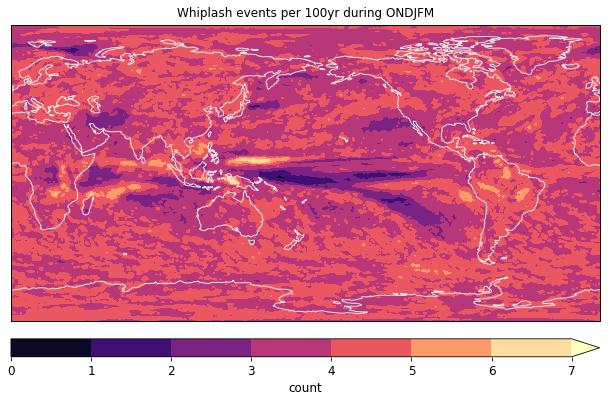

In [89]:
fontsize=12

map_proj = cartopy.crs.PlateCarree(central_longitude=180)
data_proj = cartopy.crs.PlateCarree(central_longitude=0)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines(color='0.9')

ax.text(s='Whiplash events per 100yr during '+SEAS_name, x=0.5, y=1.02, ha='center', va='bottom', fontsize=fontsize, \
       transform=ax.transAxes)

clevels = numpy.arange(0,7.1,1)
plot = ax.contourf(lon_full, lat_full, pic_whiplash_count_normalized, \
                   levels=clevels, \
                   transform=data_proj, \
                   cmap='magma', extend='max')

fig.tight_layout()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0, axpos.y0-.1, axpos.width, 0.05])
cbar_ax.tick_params(labelsize=fontsize)

cbar = fig.colorbar(plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('count', fontsize=fontsize)

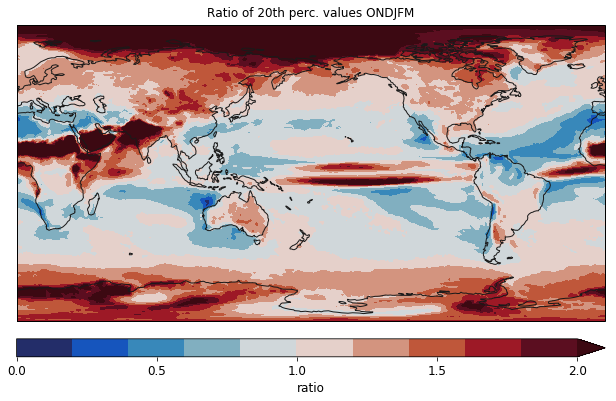

In [101]:
fontsize=12

map_proj = cartopy.crs.PlateCarree(central_longitude=180)
data_proj = cartopy.crs.PlateCarree(central_longitude=0)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines(color='0.1')

ax.text(s='Ratio of 20th perc. values '+SEAS_name, x=0.5, y=1.02, ha='center', va='bottom', fontsize=fontsize, \
       transform=ax.transAxes)

clevels = numpy.arange(0,2.1,0.2)
plot = ax.contourf(lon_full, lat_full, rcp_lo_percentile_values/pic_lo_percentile_values, \
                   levels=clevels, \
                   transform=data_proj, \
                   cmap=cmocean.cm.balance, extend='max')

fig.tight_layout()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0, axpos.y0-.1, axpos.width, 0.05])
cbar_ax.tick_params(labelsize=fontsize)

cbar = fig.colorbar(plot, orientation='horizontal',cax=cbar_ax)
cbar.set_ticks([0,0.5,1,1.5,2])
cbar.set_label('ratio', fontsize=fontsize)

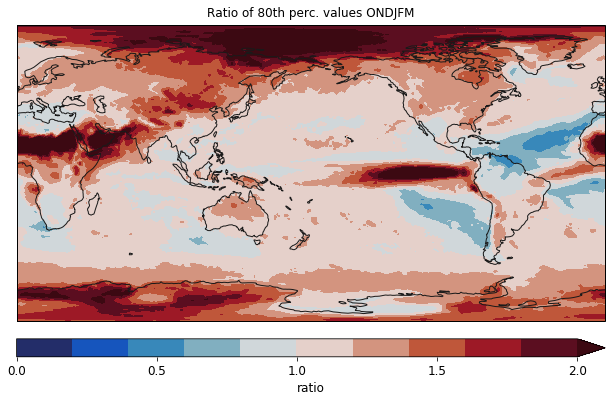

In [100]:
fontsize=12

map_proj = cartopy.crs.PlateCarree(central_longitude=180)
data_proj = cartopy.crs.PlateCarree(central_longitude=0)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines(color='0.1')

ax.text(s='Ratio of 80th perc. values '+SEAS_name, x=0.5, y=1.02, ha='center', va='bottom', fontsize=fontsize, \
       transform=ax.transAxes)

clevels = numpy.arange(0,2.1,0.2)
plot = ax.contourf(lon_full, lat_full, rcp_hi_percentile_values/pic_hi_percentile_values, \
                   levels=clevels, \
                   transform=data_proj, \
                   cmap=cmocean.cm.balance, extend='max')

fig.tight_layout()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0, axpos.y0-.1, axpos.width, 0.05])
cbar_ax.tick_params(labelsize=fontsize)

cbar = fig.colorbar(plot, orientation='horizontal',cax=cbar_ax)
cbar.set_ticks([0,0.5,1,1.5,2])
cbar.set_label('ratio', fontsize=fontsize)

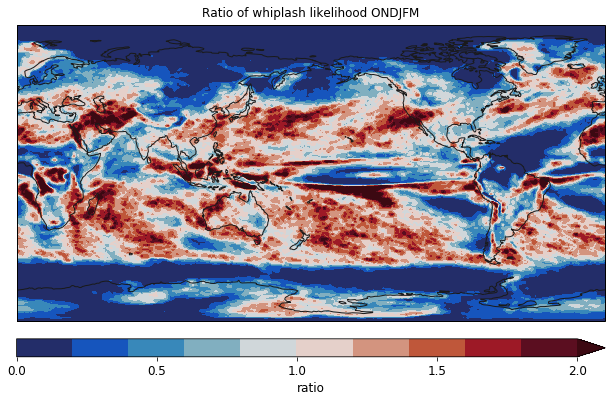

In [90]:
fontsize=12

map_proj = cartopy.crs.PlateCarree(central_longitude=180)
data_proj = cartopy.crs.PlateCarree(central_longitude=0)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines(color='0.1')

ax.text(s='Ratio of whiplash likelihood '+SEAS_name, x=0.5, y=1.02, ha='center', va='bottom', fontsize=fontsize, \
       transform=ax.transAxes)

clevels = numpy.arange(0,2.1,0.2)
plot = ax.contourf(lon_full, lat_full, rcp_whiplash_count_normalized/pic_whiplash_count_normalized, \
                   levels=clevels, \
                   transform=data_proj, \
                   cmap=cmocean.cm.balance, extend='max')

fig.tight_layout()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0, axpos.y0-.1, axpos.width, 0.05])
cbar_ax.tick_params(labelsize=fontsize)

cbar = fig.colorbar(plot, orientation='horizontal',cax=cbar_ax)
cbar.set_ticks([0,0.5,1,1.5,2])
cbar.set_label('ratio', fontsize=fontsize)

# just stdev ratios

In [91]:
PRECT_pic_seas_means_std = numpy.std(PRECT_pic_seas_means, axis=0, ddof=1)
PRECT_rcp_seas_means_std = numpy.std(PRECT_rcp_seas_means, axis=1, ddof=1)
PRECT_rcp_seas_means_std_ensmean = numpy.mean(PRECT_rcp_seas_means_std, axis=0)

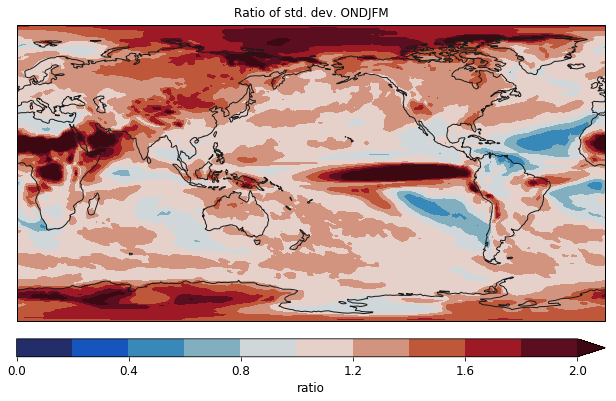

In [96]:
fontsize=12

map_proj = cartopy.crs.PlateCarree(central_longitude=180)
data_proj = cartopy.crs.PlateCarree(central_longitude=0)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines(color='0.1')

ax.text(s='Ratio of std. dev. '+SEAS_name, x=0.5, y=1.02, ha='center', va='bottom', fontsize=fontsize, \
       transform=ax.transAxes)

clevels = numpy.arange(0,2.1,0.2)
plot = ax.contourf(lon_full, lat_full, PRECT_rcp_seas_means_std_ensmean/PRECT_pic_seas_means_std, \
                   levels=clevels, \
                   transform=data_proj, \
                   cmap=cmocean.cm.balance, extend='max')

fig.tight_layout()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0, axpos.y0-.1, axpos.width, 0.05])
cbar_ax.tick_params(labelsize=fontsize)

cbar = fig.colorbar(plot, orientation='horizontal',cax=cbar_ax)
#cbar.set_ticks([0,0.5,1,1.5,2])
cbar.set_label('ratio', fontsize=fontsize)

# now do whiplash from very low season to a single month with large precip

1. Identify which years (for beginning of season) had low precip
2. Then use full data set to identify the dry years plus very wet following years

In [44]:
# shave off the first and last month because they don't have a full seasonal mean
pic_time_datetime_seas_endmonths = pic_time_datetime[pic_seas_endmonth_indices][1:-1]

In [45]:
monthly_percentile = 95

PRECT_pic_12by1801 = PRECT_pic.reshape((-1,12,lat_full.size,lon_full.size))
PRECT_pic_12by1801.shape
PRECT_pic_monthly_percentile = numpy.percentile(PRECT_pic_12by1801, q=monthly_percentile, axis=0)

In [48]:
# pic_whiplash_ds2wm = numpy.zeros((lat_full.size, lon_full.size))

# endmonth = pic_time_datetime_seas_endmonths[0].month
# if endmonth>1:
#     endmonth_idx = endmonth-1
# else:
#     endmonth_idx = 11

# for y in range(pic_nyears_seas_means):
#     print(y)
#     for j in range(lat_full.size):
#         for k in range(lon_full.size):
#             if PRECT_pic_seas_means[y,j,k] < PRECT_pic_20th[j,k]:
                
#                 dry_time = pic_time_datetime_seas_endmonths[y]
#                 full_pic_datetime_endmonth_index = numpy.where(pic_time_datetime==dry_time)[0][0]
#                 next_year_months = PRECT_pic[(full_pic_datetime_endmonth_index+12-window_length):(full_pic_datetime_endmonth_index+12),j,k]
#                 monthly_percentiles = PRECT_pic_monthly_percentile[(endmonth_idx-6):endmonth_idx,j,k]
                
#                 if sum(next_year_months>monthly_percentiles)>0:
#                     pic_whiplash_ds2wm[j,k]+=1
#             else:
#                 pass


In [177]:
# ds 2 wm
pic_whiplash_ds2wm = numpy.zeros((lat_full.size, lon_full.size))

endmonth = pic_time_datetime_seas_endmonths[0].month
if endmonth>1:
    endmonth_idx = endmonth-1
else:
     endmonth_idx = 11

date_lat_lon_list = []

for y in range(pic_nyears_seas_means):
    if y%100==0:
        print(y)
    for j in range(lat_full.size):
        for k in range(lon_full.size):
            if PRECT_pic_seas_means[y,j,k] < PRECT_pic_20th[j,k]:
                date_lat_lon_list.append((pic_time_datetime_seas_endmonths[y],j,k))
#                 dry_time = pic_time_datetime_seas_endmonths[y]
#                 full_pic_datetime_endmonth_index = numpy.where(pic_time_datetime==dry_time)[0][0]
#                 next_year_months = PRECT_pic[(full_pic_datetime_endmonth_index+12-window_length):(full_pic_datetime_endmonth_index+12),j,k]
#                 monthly_percentiles = PRECT_pic_monthly_percentile[(endmonth_idx-6):endmonth_idx,j,k]
                
#                 if sum(next_year_months>monthly_percentiles)>0:
#                     pic_whiplash_ds2wm[j,k]+=1
#             else:
#                 pass

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


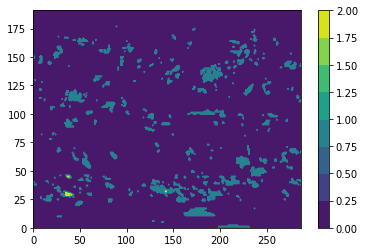

In [174]:
mp.contourf(pic_whiplash_ds2wm);mp.colorbar()

In [61]:
PRECT_pic_seas_means.shape

(1799, 192, 288)